Results for a 80/20 train/test split and batch size 442 with learning rate 0.5:
Iterations: 100000 | Epochs (approx): 9979.68 | Time: 6.3753 s

Feature names and their corresponding weights:
age: 0.07586093465429106
sex: 0.1934321634571289
test_time: 0.005257310669879534
total_UPDRS: 7.11620159869135
Jitter(%): 0.499024788888919
Jitter(Abs): -0.9040166376857187
Shimmer: 0.16596007699452517
NHR: -0.18912600715180417
HNR: -0.12894854332577613
RPDE: -0.2868508234226088
DFA: -0.0356187808540946
PPE: 0.5255747385895371

Results for train set:
MSE: 6.740100792653794
RMSE: 2.596170409016672
R^2: 0.8857597360900064

Results for test set:
MSE: 5.825046724327005
RMSE: 2.4135133569812712
R^2: 0.8884981291267445


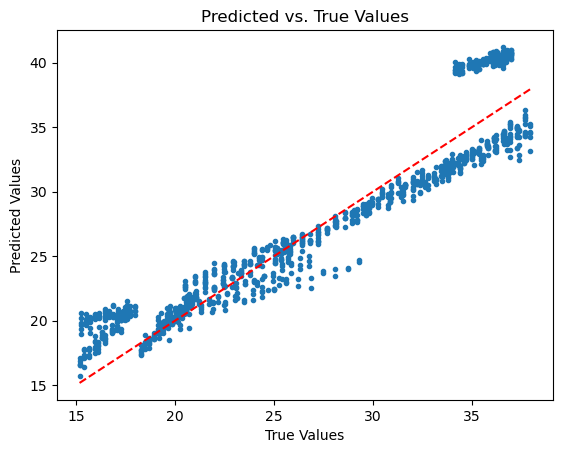

In [241]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
from scipy import stats
import time
%matplotlib inline


alpha = 0.5      
split = 80        
batch = 10  

# Fetch Dataset
df = pd.read_csv("/Users/KkJekz/Desktop/School/COMP 551/parkinsons_updrs.csv")
pd.set_option('display.max_columns', None)

# Data 
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

# Get correlation matrix
corr = abs(X.corr())
# Get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0
        pass

    def fit(self,x,y):
        if hasattr(y,'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        
        # Gradient descent
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)

        start = time.perf_counter()

        
        while np.linalg.norm(g) > self.epsilon and t <= self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1
            
            self.seconds_ = time.perf_counter() - start
            self.iters_ = t - 1
            self.epochs_ = (self.iters_ * batch_size) / N 
            
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = np.dot(x,self.w)
        grad = np.dot(x.T,(yh - y)) / N
        return grad

# Split Data
train_range = int(split / 100 * len(X)) 
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)


# Fit and Predict
model = LinearRegression(learning_rate=alpha)
model.fit(X_train, Y_train)

# Predictions
yh_train = model.predict(X_train)
yh_test  = model.predict(X_predict)

# Metrics
mse_train = np.mean((Y_train.values.flatten()   - yh_train)**2)
rmse_train = np.sqrt(mse_train)
mse_test  = np.mean((Y_predict.values.flatten() - yh_test )**2)
rmse_test = np.sqrt(mse_test)

def R2(y, yh):
    y = y.values.flatten()
    y_mean = np.mean(y)
    ss_res = np.sum((y - yh)**2)
    ss_tot = np.sum((y - y_mean)**2)
    return 1 - ss_res/ss_tot


batch_size = int(batch * X_train.shape[0] / 100)

print(f'Results for a {split}/{100 - split} train/test split and batch size {batch_size} with learning rate {alpha}:')
print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')
print('\nFeature names and their corresponding weights:')
for i, col in enumerate(X.columns):
    print(f"{col}: {model.w[i]}")

print('\nResults for train set:')
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R^2: {R2(Y_train, yh_train)}")

print('\nResults for test set:')
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {R2(Y_predict, yh_test)}")

# Plot
plt.plot(Y_predict.values, yh_test, '.')
ymin, ymax = float(Y_predict.values.min()), float(Y_predict.values.max())
plt.plot([ymin, ymax], [ymin, ymax], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()


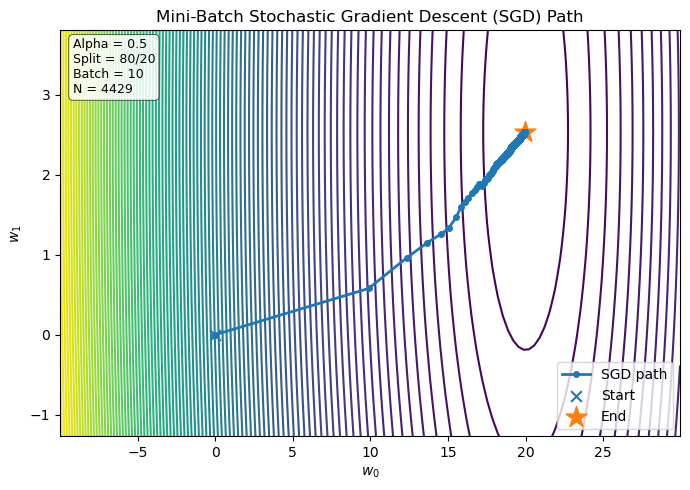

In [243]:
# Contour map of linear regression loss function + SGD path 
import itertools
import numpy as np
import matplotlib.pyplot as plt


feat_idx = 0
x = X_train[:, feat_idx]                 
y = Y_train.values.flatten()           


cost = lambda w0, w1: 0.5 * np.mean((w0 + w1 * x - y) ** 2)

def plot_contour(f, x1bound, x2bound, resolution, ax):
    # Function to plot the contours where f is the cost function
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f(xg[i, j], yg[i, j])
    ax.contour(xg, yg, zg, 100)  
    return ax

# Mini-batch SGD 
def gd_path_1d(x_vec, y_vec, lr, batch_percent, epsilon=1e-4, max_iter=1e5, seed=0):
    if x_vec.ndim == 1:
        x_vec = x_vec[:, None]
    N = x_vec.shape[0]
    Xaug = np.column_stack([np.ones(N), x_vec]) 
    w = np.zeros(2)
    path = [w.copy()]
    rng = np.random.default_rng(seed)
    g = np.inf
    t = 1
    bs = max(1, int(batch_percent * N / 100))
    while np.linalg.norm(g) > epsilon and t <= max_iter:
        idx = rng.choice(N, size=bs, replace=False)
        Xb = Xaug[idx]
        yb = y_vec[idx]
        yh = Xb @ w
        g = (Xb.T @ (yh - yb)) / Xb.shape[0]
        w = w - (lr / t) * g
        path.append(w.copy())
        t += 1
    return np.array(path), bs, N

# SGD path
path, batch_size_eff, N_train = gd_path_1d(x, y, lr=alpha, batch_percent=batch)

# Bounds around the path
w0_min, w0_max = path[:,0].min(), path[:,0].max()
w1_min, w1_max = path[:,1].min(), path[:,1].max()
pad0 = 0.5 * max(1e-3, abs(w0_max - w0_min))
pad1 = 0.5 * max(1e-3, abs(w1_max - w1_min))
w0_bounds = [w0_min - pad0, w0_max + pad0]
w1_bounds = [w1_min - pad1, w1_max + pad1]

# Plot contour + SGD path
fig, ax = plt.subplots(figsize=(7,5))
plot_contour(cost, w0_bounds, w1_bounds, 120, ax)
ax.plot(path[:,0], path[:,1], 'o-', lw=2, ms=4, label='SGD path')
ax.scatter(path[0,0], path[0,1], s=60, marker='x', label='Start')
ax.scatter(path[-1,0], path[-1,1], s=250, marker='*', label='End')
ax.set_xlabel(r'$w_0$')
ax.set_ylabel(r'$w_1$')
ax.set_title('Mini-Batch Stochastic Gradient Descent (SGD) Path')

# Info
info = f"Alpha = {alpha}\nSplit = {split}/{100 - split}\nBatch = {batch}\nN = {N_train}"
ax.text(0.02, 0.98, info, transform=ax.transAxes,
        ha='left', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, lw=0.5))
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


Results for a 80/20 train/test split and batch size 442 with learning rate 1:
Iterations: 100000 | Epochs (approx): 9979.68 | Time: 6.3404 s

Feature names and their corresponding weights:
age: -0.018577533759031702
sex: 0.10422421041781674
test_time: -0.033622551084154836
total_UPDRS: 7.2710739712436085
Jitter(%): 0.7727486352080424
Jitter(Abs): -1.3959967415375407
Shimmer: 0.2253558186698734
NHR: -0.1251022214873453
HNR: -0.007911233595391651
RPDE: -0.3180776815435923
DFA: 0.10162722057249664
PPE: 0.6684361997867556

Results for train set:
MSE: 6.589177701778964
RMSE: 2.5669393646479
R^2: 0.8883177829593417

Results for test set:
MSE: 6.229660116854039
RMSE: 2.4959287082875665
R^2: 0.8807531010810937


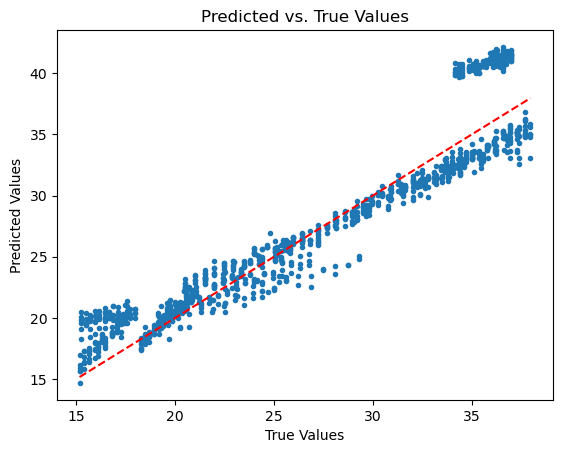

In [245]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
from scipy import stats
import time
%matplotlib inline


alpha = 1      
split = 80        
batch = 10  

# Fetch Dataset
df = pd.read_csv("/Users/KkJekz/Desktop/School/COMP 551/parkinsons_updrs.csv")
pd.set_option('display.max_columns', None)

# Data 
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

# Get correlation matrix
corr = abs(X.corr())
# Get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0
        pass

    def fit(self,x,y):
        if hasattr(y,'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        
        # Gradient descent
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)

        start = time.perf_counter()

        
        while np.linalg.norm(g) > self.epsilon and t <= self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1
            
            self.seconds_ = time.perf_counter() - start
            self.iters_ = t - 1
            self.epochs_ = (self.iters_ * batch_size) / N 
            
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = np.dot(x,self.w)
        grad = np.dot(x.T,(yh - y)) / N
        return grad

# Split Data
train_range = int(split / 100 * len(X)) 
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)


# Fit and Predict
model = LinearRegression(learning_rate=alpha)
model.fit(X_train, Y_train)

# Predictions
yh_train = model.predict(X_train)
yh_test  = model.predict(X_predict)

# Metrics
mse_train = np.mean((Y_train.values.flatten()   - yh_train)**2)
rmse_train = np.sqrt(mse_train)
mse_test  = np.mean((Y_predict.values.flatten() - yh_test )**2)
rmse_test = np.sqrt(mse_test)

def R2(y, yh):
    y = y.values.flatten()
    y_mean = np.mean(y)
    ss_res = np.sum((y - yh)**2)
    ss_tot = np.sum((y - y_mean)**2)
    return 1 - ss_res/ss_tot


batch_size = int(batch * X_train.shape[0] / 100)

print(f'Results for a {split}/{100 - split} train/test split and batch size {batch_size} with learning rate {alpha}:')
print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')
print('\nFeature names and their corresponding weights:')
for i, col in enumerate(X.columns):
    print(f"{col}: {model.w[i]}")

print('\nResults for train set:')
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R^2: {R2(Y_train, yh_train)}")

print('\nResults for test set:')
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {R2(Y_predict, yh_test)}")

# Plot
plt.plot(Y_predict.values, yh_test, '.')
ymin, ymax = float(Y_predict.values.min()), float(Y_predict.values.max())
plt.plot([ymin, ymax], [ymin, ymax], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()

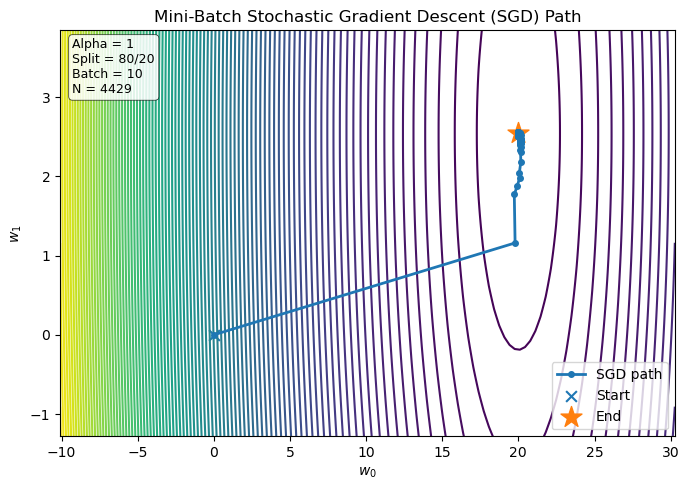

In [247]:
# Contour map of linear regression loss function + SGD path 
import itertools
import numpy as np
import matplotlib.pyplot as plt


feat_idx = 0
x = X_train[:, feat_idx]                 
y = Y_train.values.flatten()           


cost = lambda w0, w1: 0.5 * np.mean((w0 + w1 * x - y) ** 2)

def plot_contour(f, x1bound, x2bound, resolution, ax):
    # Function to plot the contours where f is the cost function
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f(xg[i, j], yg[i, j])
    ax.contour(xg, yg, zg, 100)  
    return ax

# Mini-batch SGD 
def gd_path_1d(x_vec, y_vec, lr, batch_percent, epsilon=1e-4, max_iter=1e5, seed=0):
    if x_vec.ndim == 1:
        x_vec = x_vec[:, None]
    N = x_vec.shape[0]
    Xaug = np.column_stack([np.ones(N), x_vec]) 
    w = np.zeros(2)
    path = [w.copy()]
    rng = np.random.default_rng(seed)
    g = np.inf
    t = 1
    bs = max(1, int(batch_percent * N / 100))
    while np.linalg.norm(g) > epsilon and t <= max_iter:
        idx = rng.choice(N, size=bs, replace=False)
        Xb = Xaug[idx]
        yb = y_vec[idx]
        yh = Xb @ w
        g = (Xb.T @ (yh - yb)) / Xb.shape[0]
        w = w - (lr / t) * g
        path.append(w.copy())
        t += 1
    return np.array(path), bs, N

# SGD path
path, batch_size_eff, N_train = gd_path_1d(x, y, lr=alpha, batch_percent=batch)

# Bounds around the path
w0_min, w0_max = path[:,0].min(), path[:,0].max()
w1_min, w1_max = path[:,1].min(), path[:,1].max()
pad0 = 0.5 * max(1e-3, abs(w0_max - w0_min))
pad1 = 0.5 * max(1e-3, abs(w1_max - w1_min))
w0_bounds = [w0_min - pad0, w0_max + pad0]
w1_bounds = [w1_min - pad1, w1_max + pad1]

# Plot contour + SGD path
fig, ax = plt.subplots(figsize=(7,5))
plot_contour(cost, w0_bounds, w1_bounds, 120, ax)
ax.plot(path[:,0], path[:,1], 'o-', lw=2, ms=4, label='SGD path')
ax.scatter(path[0,0], path[0,1], s=60, marker='x', label='Start')
ax.scatter(path[-1,0], path[-1,1], s=250, marker='*', label='End')
ax.set_xlabel(r'$w_0$')
ax.set_ylabel(r'$w_1$')
ax.set_title('Mini-Batch Stochastic Gradient Descent (SGD) Path')

# Info
info = f"Alpha = {alpha}\nSplit = {split}/{100 - split}\nBatch = {batch}\nN = {N_train}"
ax.text(0.02, 0.98, info, transform=ax.transAxes,
        ha='left', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, lw=0.5))
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

Results for a 80/20 train/test split and batch size 442 with learning rate 2:
Iterations: 100000 | Epochs (approx): 9979.68 | Time: 6.3222 s

Feature names and their corresponding weights:
age: -0.03327167069108641
sex: -0.18817351490151404
test_time: -0.04435284914681424
total_UPDRS: 7.259755935793515
Jitter(%): 1.9597915352898387
Jitter(Abs): -2.67084858577949
Shimmer: 0.14984936633670132
NHR: -0.20488186194463628
HNR: -0.028702962070313486
RPDE: -0.1497732261204177
DFA: 0.1979146581543767
PPE: 0.5978232548499492

Results for train set:
MSE: 6.467390169489409
RMSE: 2.5431064015273543
R^2: 0.8903820013230893

Results for test set:
MSE: 6.982051933333549
RMSE: 2.6423572682991883
R^2: 0.8663509685081768


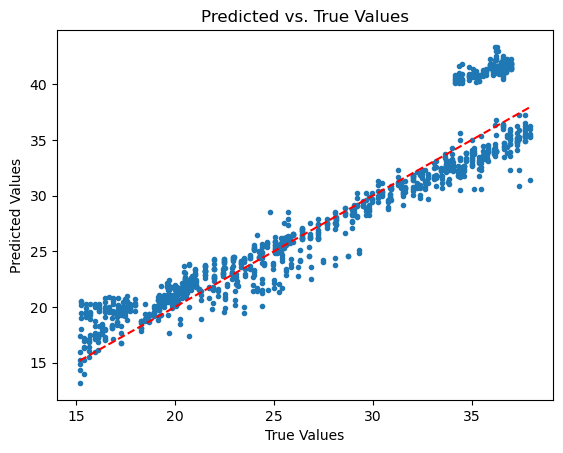

In [249]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import argparse
from scipy import stats
import time
%matplotlib inline


alpha = 2      
split = 80        
batch = 10  

# Fetch Dataset
df = pd.read_csv("/Users/KkJekz/Desktop/School/COMP 551/parkinsons_updrs.csv")
pd.set_option('display.max_columns', None)

# Data 
X = df.drop(columns=['motor_UPDRS', 'subject#']) #Features
Y = df[['motor_UPDRS']] #Target

# Get correlation matrix
corr = abs(X.corr())
# Get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% (0.1 above and 0.1 below the mean) of data in a normally distributed dataset will fall in this range
outlier_indices = np.where(z > 3)[0]
X = X.drop(outlier_indices)
Y = Y.drop(outlier_indices)

class LinearRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0
        pass

    def fit(self,x,y):
        if hasattr(y,'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        
        # Gradient descent
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)

        start = time.perf_counter()

        
        while np.linalg.norm(g) > self.epsilon and t <= self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1
            
            self.seconds_ = time.perf_counter() - start
            self.iters_ = t - 1
            self.epochs_ = (self.iters_ * batch_size) / N 
            
        return self

    def predict(self,x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = np.dot(x,self.w)
        grad = np.dot(x.T,(yh - y)) / N
        return grad

# Split Data
train_range = int(split / 100 * len(X)) 
X_train = X.iloc[:train_range]
X_predict = X.iloc[train_range:]
Y_train = Y.iloc[:train_range]
Y_predict = Y.iloc[train_range:]

# Scale Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_predict = scaler.transform(X_predict)


# Fit and Predict
model = LinearRegression(learning_rate=alpha)
model.fit(X_train, Y_train)

# Predictions
yh_train = model.predict(X_train)
yh_test  = model.predict(X_predict)

# Metrics
mse_train = np.mean((Y_train.values.flatten()   - yh_train)**2)
rmse_train = np.sqrt(mse_train)
mse_test  = np.mean((Y_predict.values.flatten() - yh_test )**2)
rmse_test = np.sqrt(mse_test)

def R2(y, yh):
    y = y.values.flatten()
    y_mean = np.mean(y)
    ss_res = np.sum((y - yh)**2)
    ss_tot = np.sum((y - y_mean)**2)
    return 1 - ss_res/ss_tot


batch_size = int(batch * X_train.shape[0] / 100)

print(f'Results for a {split}/{100 - split} train/test split and batch size {batch_size} with learning rate {alpha}:')
print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')
print('\nFeature names and their corresponding weights:')
for i, col in enumerate(X.columns):
    print(f"{col}: {model.w[i]}")

print('\nResults for train set:')
print(f"MSE: {mse_train}")
print(f"RMSE: {rmse_train}")
print(f"R^2: {R2(Y_train, yh_train)}")

print('\nResults for test set:')
print(f"MSE: {mse_test}")
print(f"RMSE: {rmse_test}")
print(f"R^2: {R2(Y_predict, yh_test)}")

# Plot
plt.plot(Y_predict.values, yh_test, '.')
ymin, ymax = float(Y_predict.values.min()), float(Y_predict.values.max())
plt.plot([ymin, ymax], [ymin, ymax], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.show()

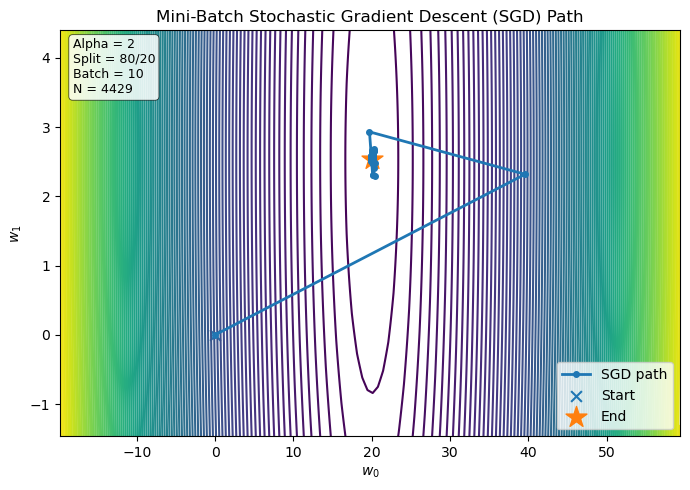

In [251]:
# Contour map of linear regression loss function + SGD path 
import itertools
import numpy as np
import matplotlib.pyplot as plt


feat_idx = 0
x = X_train[:, feat_idx]                 
y = Y_train.values.flatten()           


cost = lambda w0, w1: 0.5 * np.mean((w0 + w1 * x - y) ** 2)

def plot_contour(f, x1bound, x2bound, resolution, ax):
    # Function to plot the contours where f is the cost function
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i, j in itertools.product(range(resolution), range(resolution)):
        zg[i, j] = f(xg[i, j], yg[i, j])
    ax.contour(xg, yg, zg, 100)  
    return ax

# Mini-batch SGD 
def gd_path_1d(x_vec, y_vec, lr, batch_percent, epsilon=1e-4, max_iter=1e5, seed=0):
    if x_vec.ndim == 1:
        x_vec = x_vec[:, None]
    N = x_vec.shape[0]
    Xaug = np.column_stack([np.ones(N), x_vec]) 
    w = np.zeros(2)
    path = [w.copy()]
    rng = np.random.default_rng(seed)
    g = np.inf
    t = 1
    bs = max(1, int(batch_percent * N / 100))
    while np.linalg.norm(g) > epsilon and t <= max_iter:
        idx = rng.choice(N, size=bs, replace=False)
        Xb = Xaug[idx]
        yb = y_vec[idx]
        yh = Xb @ w
        g = (Xb.T @ (yh - yb)) / Xb.shape[0]
        w = w - (lr / t) * g
        path.append(w.copy())
        t += 1
    return np.array(path), bs, N

# SGD path
path, batch_size_eff, N_train = gd_path_1d(x, y, lr=alpha, batch_percent=batch)

# Bounds around the path
w0_min, w0_max = path[:,0].min(), path[:,0].max()
w1_min, w1_max = path[:,1].min(), path[:,1].max()
pad0 = 0.5 * max(1e-3, abs(w0_max - w0_min))
pad1 = 0.5 * max(1e-3, abs(w1_max - w1_min))
w0_bounds = [w0_min - pad0, w0_max + pad0]
w1_bounds = [w1_min - pad1, w1_max + pad1]

# Plot contour + SGD path
fig, ax = plt.subplots(figsize=(7,5))
plot_contour(cost, w0_bounds, w1_bounds, 120, ax)
ax.plot(path[:,0], path[:,1], 'o-', lw=2, ms=4, label='SGD path')
ax.scatter(path[0,0], path[0,1], s=60, marker='x', label='Start')
ax.scatter(path[-1,0], path[-1,1], s=250, marker='*', label='End')
ax.set_xlabel(r'$w_0$')
ax.set_ylabel(r'$w_1$')
ax.set_title('Mini-Batch Stochastic Gradient Descent (SGD) Path')

# Info
info = f"Alpha = {alpha}\nSplit = {split}/{100 - split}\nBatch = {batch}\nN = {N_train}"
ax.text(0.02, 0.98, info, transform=ax.transAxes,
        ha='left', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.85, lw=0.5))
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

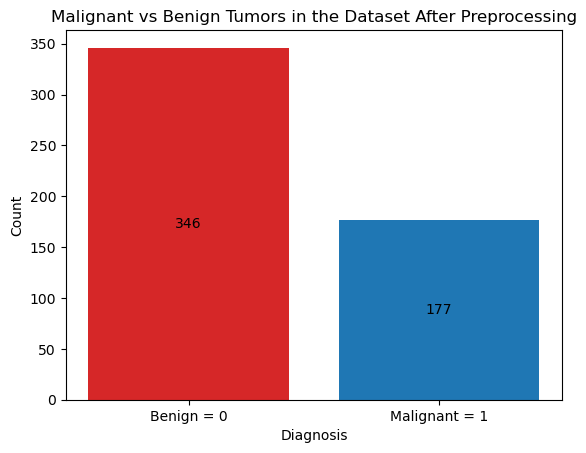

Results for a 80/20 train/test split and batch size 41 with learning rate 5:
94/105 correct classifications (89.52% accuracy)
Iterations: 99999 | Epochs (approx): 9808.51 | Time: 1.5355 s


In [253]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
from scipy import stats
import time
%matplotlib inline

batch_size = 0

# Manual args 
alpha = 5        
split = 80        
batch = 10       

# Headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") 
    wdbcHeaders.insert(2*i+3, features[i]+"2") 
    wdbcHeaders.insert(2*i+4, features[i]+"3") 

breast_cancer_wisconsin_diagnostic = pd.read_csv('/Users/KkJekz/Desktop/School/COMP 551/wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) # features
X = X.drop(X.iloc[:, 10:20], axis=1) # drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() # target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

# Get correlation matrix
corr = abs(X.corr())
# Get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% of data in a normally distributed dataset will fall in this range
outlier_mask = (z>3).any(axis=1)
X = X[~outlier_mask]
Y = Y[~outlier_mask]

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) 
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0

    def fit(self,x,y):
        
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)  
       
        # Gradient descent

        start = time.perf_counter() 
        
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1

        self.seconds_ = time.perf_counter() - start
        self.iters_ = t - 1
        self.epochs_ = (self.iters_ * batch_size) / N

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad


def logistic_success_rate(y_predicted, y):
    N = len(y_predicted)
    y = np.array(y)
    yp = y_predicted.round()  
    error = abs(yp-y)        
    return round((N-error.sum())/N*100, 2)

def test_logistic_regression(x, y, split_percent, learning_rate): 
    train_range = int(len(x) * split_percent / 100)
    
    # Split data 
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]
    
    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh = model.predict(X_test)
    y = y_test['Diagnosis'].to_numpy()

    matching = (yh.round() == y).sum()  # Number of correct classifications
    test_total = len(y_test)
    
    # Print results (only test data)
    print(f'Results for a {split}/{100 - split} train/test split and batch size {batch_size} with learning rate {alpha}:')
    print(f'{matching}/{test_total} correct classifications ({round(matching * 100 / test_total, 2)}% accuracy)')
    print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')

# Run the test using the manual args
test_logistic_regression(X, Y, split, alpha)


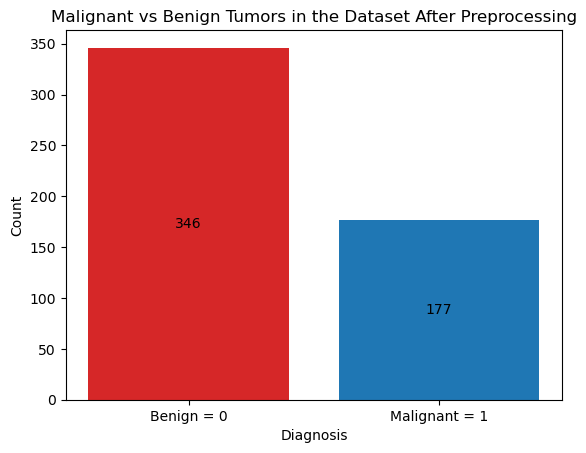

Results for a 80/20 train/test split and batch size 41 with learning rate 10:
95/105 correct classifications (90.48% accuracy)
Iterations: 99999 | Epochs (approx): 9808.51 | Time: 1.5394 s


In [255]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
from scipy import stats
import time
%matplotlib inline

batch_size = 0

# Manual args 
alpha = 10        
split = 80        
batch = 10       

# Headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") 
    wdbcHeaders.insert(2*i+3, features[i]+"2") 
    wdbcHeaders.insert(2*i+4, features[i]+"3") 

breast_cancer_wisconsin_diagnostic = pd.read_csv('/Users/KkJekz/Desktop/School/COMP 551/wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) # features
X = X.drop(X.iloc[:, 10:20], axis=1) # drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() # target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

# Get correlation matrix
corr = abs(X.corr())
# Get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% of data in a normally distributed dataset will fall in this range
outlier_mask = (z>3).any(axis=1)
X = X[~outlier_mask]
Y = Y[~outlier_mask]

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) 
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0

    def fit(self,x,y):
        
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)  
       
        # Gradient descent

        start = time.perf_counter() 
        
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1

        self.seconds_ = time.perf_counter() - start
        self.iters_ = t - 1
        self.epochs_ = (self.iters_ * batch_size) / N

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad


def logistic_success_rate(y_predicted, y):
    N = len(y_predicted)
    y = np.array(y)
    yp = y_predicted.round()  
    error = abs(yp-y)        
    return round((N-error.sum())/N*100, 2)

def test_logistic_regression(x, y, split_percent, learning_rate): 
    train_range = int(len(x) * split_percent / 100)
    
    # Split data 
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]
    
    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh = model.predict(X_test)
    y = y_test['Diagnosis'].to_numpy()

    matching = (yh.round() == y).sum()  # Number of correct classifications
    test_total = len(y_test)
    
    # Print results (only test data)
    print(f'Results for a {split}/{100 - split} train/test split and batch size {batch_size} with learning rate {alpha}:')
    print(f'{matching}/{test_total} correct classifications ({round(matching * 100 / test_total, 2)}% accuracy)')
    print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')

# Run the test using the manual args
test_logistic_regression(X, Y, split, alpha)

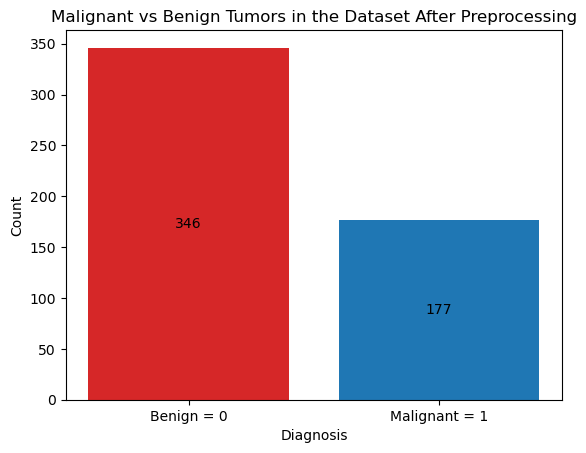

Results for a 80/20 train/test split and batch size 41 with learning rate 15:
98/105 correct classifications (93.33% accuracy)
Iterations: 99999 | Epochs (approx): 9808.51 | Time: 1.5272 s


In [257]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.special import expit as logistic
from scipy import stats
import time
%matplotlib inline

batch_size = 0

# Manual args 
alpha = 15        
split = 80        
batch = 10       

# Headers
wdbcHeaders = ["ID", "Diagnosis"]
features = ["radius", "texture", "perimeter", "area", "smoothness", "compactness", "concavity", "concave_points", "symmetry", "fractal_dimension"]
for i in range(len(features)):
    wdbcHeaders.insert(i+2, features[i]+"1") 
    wdbcHeaders.insert(2*i+3, features[i]+"2") 
    wdbcHeaders.insert(2*i+4, features[i]+"3") 

breast_cancer_wisconsin_diagnostic = pd.read_csv('/Users/KkJekz/Desktop/School/COMP 551/wdbc_diagnosis.csv', header=None, names=wdbcHeaders)
pd.set_option('display.max_columns', None)

X = breast_cancer_wisconsin_diagnostic.drop(columns =['Diagnosis', 'ID']) # features
X = X.drop(X.iloc[:, 10:20], axis=1) # drop standard error features
Y = breast_cancer_wisconsin_diagnostic[['Diagnosis']].copy() # target

# Convert string labels to numeric: 'M' (malignant) = 1, 'B' (benign) = 0
Y['Diagnosis'] = Y['Diagnosis'].map({'M': 1, 'B': 0})

# Get correlation matrix
corr = abs(X.corr())
# Get upper triangular matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
# Find features with correlation greater than 0.9 with each other 
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
# Drop highly correlated features
X = X.drop(to_drop, axis=1)

# Drop outliers with z score greater than 3 
z = np.abs(stats.zscore(X))
# ~0.2% of data in a normally distributed dataset will fall in this range
outlier_mask = (z>3).any(axis=1)
X = X[~outlier_mask]
Y = Y[~outlier_mask]

wdbc_bar = plt.bar(['Benign = 0', 'Malignant = 1'], Y.value_counts(), color=['tab:red', 'tab:blue']) 
plt.title('Malignant vs Benign Tumors in the Dataset After Preprocessing')
plt.xlabel('Diagnosis')
plt.bar_label(wdbc_bar, labels=Y.value_counts(), label_type='center')
plt.ylabel('Count')
plt.show()

class LogisticRegression:
    def __init__(self, add_bias=True, learning_rate=1., epsilon=1e-4, max_iter=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.verbose = verbose

        self.iters_ = 0
        self.epochs_ = 0.0
        self.seconds_ = 0.0

    def fit(self,x,y):
        
        if hasattr(x, 'values'):
            x = x.values
        if hasattr(y, 'values'):
            y = y.values.flatten()
        if x.ndim == 1:
            x = x[:,None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 1
        global batch_size
        batch_size = int(batch * N / 100)  
       
        # Gradient descent

        start = time.perf_counter() 
        
        while np.linalg.norm(g) > self.epsilon and t < self.max_iter:
            random_indices = np.random.choice(N,size=batch_size,replace=False)
            X_batch = x[random_indices]
            Y_batch = y[random_indices]
            g = self.gradient(X_batch,Y_batch)
            self.w = self.w - self.learning_rate / t * g
            t += 1

        self.seconds_ = time.perf_counter() - start
        self.iters_ = t - 1
        self.epochs_ = (self.iters_ * batch_size) / N

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self

    def predict(self,x):
        if hasattr(x, 'values'):
            x = x.values
        if x.ndim == 1:
            x = x[:,None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))
        return yh

    def gradient(self,x,y):
        N = x.shape[0]
        yh = logistic(np.dot(x,self.w))
        grad = np.dot(x.T, yh - y) / N
        return grad


def logistic_success_rate(y_predicted, y):
    N = len(y_predicted)
    y = np.array(y)
    yp = y_predicted.round()  
    error = abs(yp-y)        
    return round((N-error.sum())/N*100, 2)

def test_logistic_regression(x, y, split_percent, learning_rate): 
    train_range = int(len(x) * split_percent / 100)
    
    # Split data 
    X_train = x.iloc[:train_range]
    X_test = x.iloc[train_range:]
    y_train = y.iloc[:train_range]
    y_test = y.iloc[train_range:]
    
    model = LogisticRegression(learning_rate=learning_rate).fit(X_train, y_train)
    yh = model.predict(X_test)
    y = y_test['Diagnosis'].to_numpy()

    matching = (yh.round() == y).sum()  # Number of correct classifications
    test_total = len(y_test)
    
    # Print results (only test data)
    print(f'Results for a {split}/{100 - split} train/test split and batch size {batch_size} with learning rate {alpha}:')
    print(f'{matching}/{test_total} correct classifications ({round(matching * 100 / test_total, 2)}% accuracy)')
    print(f'Iterations: {model.iters_} | Epochs (approx): {model.epochs_:.2f} | Time: {model.seconds_:.4f} s')

# Run the test using the manual args
test_logistic_regression(X, Y, split, alpha)